# Previsão de temperatura com base em dados meteorológicos

Nesse notebook, vamos prosseguir com o treinamento de um modelo para prever a temperatura de um dado dia usando a biblioteca `darts`. O principal foco desse notebook não é a modelagem em si, mas o uso do `mlflow` para rastrear e registrar os experimentos.

In [ ]:
%pip install darts matplotlib pandas ipywidgets mlflow

In [2]:
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [3]:
import mlflow
from mlflow.models import infer_signature

mlflow.set_tracking_uri(uri="http://localhost:8080")

/home/kiki/Projects/analise-series-temporais-de-clima/.conda/lib/python3.11/site-packages/statsforecast/utils.py:237: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  "ds": pd.date_range(start="1949-01-01", periods=len(AirPassengers), freq="M"),


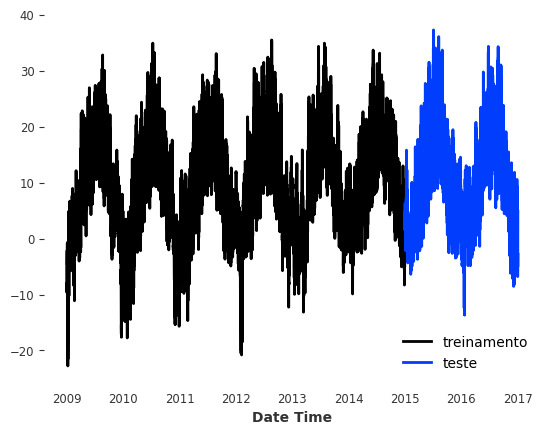

In [4]:
import matplotlib.pyplot as plt
import pickle
from darts.utils.missing_values import fill_missing_values
from darts.utils.statistics import plot_acf, check_seasonality
from darts.models import NBEATSModel
from darts.models import ExponentialSmoothing
from darts.models import NaiveSeasonal
from darts.dataprocessing.transformers import Scaler
from darts import TimeSeries
import pandas as pd
from darts.models import RegressionModel
from sklearn.ensemble import RandomForestRegressor
from darts.metrics import mse, mae, rmse


def plot_forecast(forecast, train, val, model_name):
    _, ax = plt.subplots(figsize=(12, 4))
    forecast_length = forecast.n_timesteps
    train.plot(label="treino", ax=ax, color="gray")
    val.head(forecast_length).plot(label="real", ax=ax, color="green")
    forecast.plot(label="previsão", ax=ax, color="blue")

    ax.grid(False)
    ax.text(
        0.5,
        1.2,
        f"Previsão do modelo ({model_name})",
        ha="center",
        va="center",
        fontsize=14,
        transform=ax.transAxes,
    )

    plt.show()


df = pd.read_parquet("jena_climate_2009_2016_cleaned.parquet")

series = TimeSeries.from_dataframe(
    df, time_col="Date Time", value_cols="T (degC)", freq="10min"
)

series = series.resample("1h").mean()
series = fill_missing_values(series)

train, test = series.split_before(pd.Timestamp("2015-01-01"))

ax = train.plot(label="treinamento")
test.plot(label="teste", ax=ax)

ax.grid(False)

plt.show()

### Inspecionar a sazonabilidade dos dados

Usando a função `check_seasonality` do `darts`, verificamos que há sazonalidade a cada 24 horas.

In [5]:
max_lag = 365 * 24 * 2  # 2 anos
try:
    for m in range(2, max_lag // 2):
        is_seasonal, period = check_seasonality(train, m=m, max_lag=max_lag, alpha=0.05)
        if is_seasonal:
            print("There is seasonality of order {}.".format(period))
except KeyboardInterrupt:
    print("Stopped")

There is seasonality of order 24.
There is seasonality of order 48.
There is seasonality of order 72.
There is seasonality of order 96.
There is seasonality of order 120.
Stopped


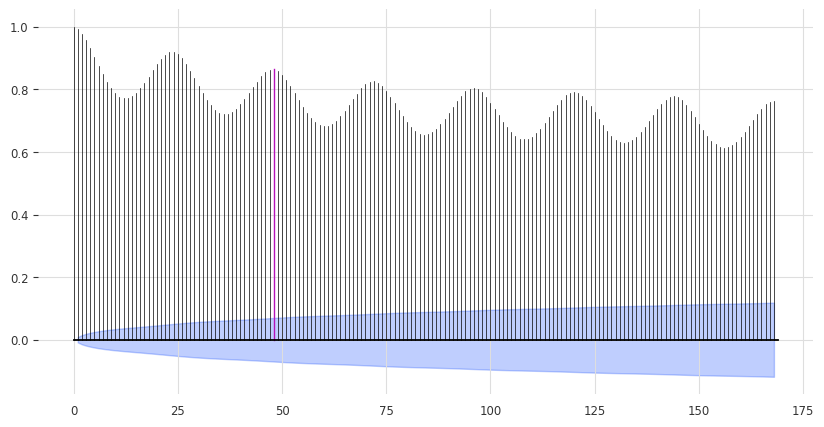

In [6]:
plot_acf(train, m=48, max_lag=168)

### Treinar modelos ingênuos de previsão de temperatura

In [7]:
scaler = Scaler()
train_transformed = scaler.fit_transform(train)

with open("scaler.pkl", "wb") as f:
    pickle.dump(scaler, f)

In [8]:
mlflow.set_experiment("jena_climate_2009_2016")

2024/03/03 17:12:44 INFO mlflow.tracking.fluent: Experiment with name 'jena_climate_2009_2016' does not exist. Creating a new experiment.


<Experiment: artifact_location='mlflow-artifacts:/167723412594169871', creation_time=1709496764182, experiment_id='167723412594169871', last_update_time=1709496764182, lifecycle_stage='active', name='jena_climate_2009_2016', tags={}>

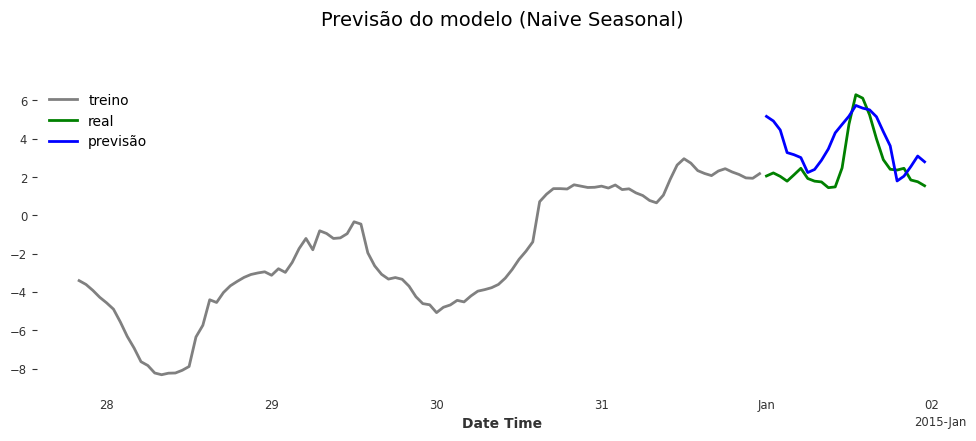

In [14]:
naive_model = NaiveSeasonal(K=168)
naive_model.fit(train_transformed)
naive_forecast = naive_model.predict(24)
naive_forecast = scaler.inverse_transform(naive_forecast)
naive_model.save("model.pkl")

with mlflow.start_run(run_name="Naive Seasonal"):

    mlflow.log_params(naive_model.model_params)

    mlflow.log_metric("mse", mse(test, naive_forecast))
    mlflow.log_metric("mae", mae(test, naive_forecast))
    mlflow.log_metric("rmse", rmse(test, naive_forecast))

    mlflow.set_tag("model", "Naive Seasonal")
    mlflow.log_artifact("model.pkl")
    mlflow.log_artifact("scaler.pkl")

    plot_forecast(naive_forecast,  train.tail(100), test, "Naive Seasonal")

/home/kiki/Projects/analise-series-temporais-de-clima/.conda/lib/python3.11/site-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


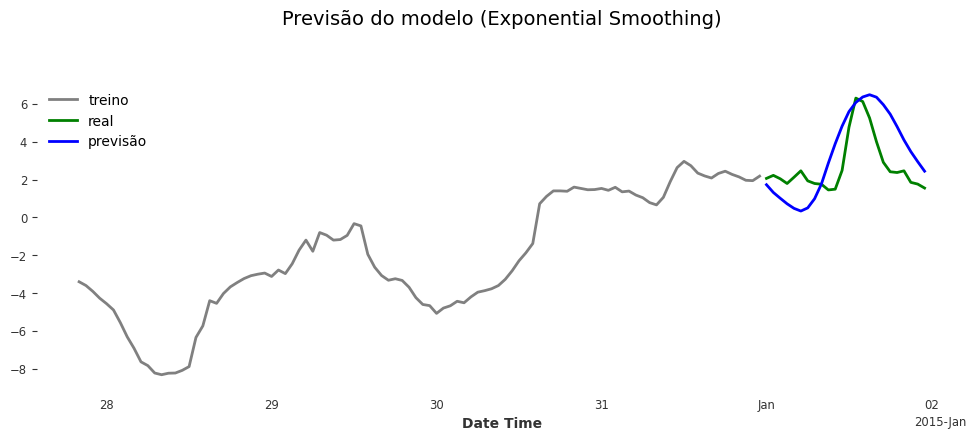

In [15]:
model = ExponentialSmoothing(seasonal_periods=168)
model.fit(train_transformed)

exp_smoothing_forecast = model.predict(24)
exp_smoothing_forecast = scaler.inverse_transform(exp_smoothing_forecast)
model.save("model.pkl")

with mlflow.start_run(run_name="Exponential Smoothing"):
    mlflow.log_params(model.model_params)

    mlflow.log_metric("mse", mse(test, exp_smoothing_forecast))
    mlflow.log_metric("mae", mae(test, exp_smoothing_forecast))
    mlflow.log_metric("rmse", rmse(test, exp_smoothing_forecast))

    mlflow.set_tag("model", "Exponential Smoothing")
    mlflow.log_artifact("model.pkl")
    mlflow.log_artifact("scaler.pkl")

    plot_forecast(exp_smoothing_forecast,  train.tail(100), test, "Exponential Smoothing")

### Treinar modelos de previsão de temperatura mais complexos

In [16]:
def extract_season_of_the_year(ts):
    # winter: 0, spring: 1, summer: 2, fall: 3
    return pd.cut(
        ts.dayofyear, [0, 78, 171, 265, 354, 366], labels=[0, 1, 2, 3, 0], ordered=False
    )

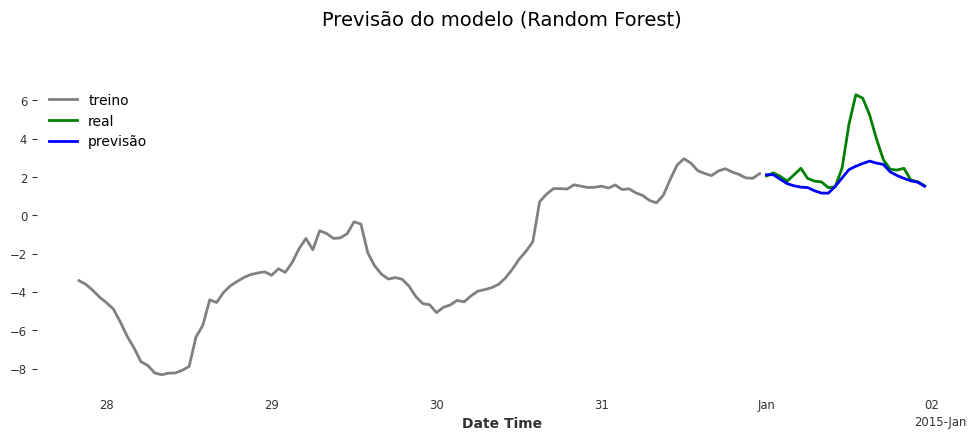

In [17]:
regressor = RandomForestRegressor(random_state=0)

model = RegressionModel(
    regressor,
    lags=24,
    output_chunk_length=24,
    lags_future_covariates=(24, 1),
    add_encoders={
        "cyclic": {"future": ["minute", "hour", "dayofweek", "month", "day"]},
        "custom": {"future": [extract_season_of_the_year]},
        "tz": "CET",
    },
)

model.fit(train_transformed)
forecast = model.predict(24)
forecast = scaler.inverse_transform(forecast)

model.save("regression_model.pkl")

with mlflow.start_run(run_name="Random Forest"):
    mlflow.log_params(model.model_params)

    mlflow.log_metric("mse", mse(test, forecast))
    mlflow.log_metric("mae", mae(test, forecast))
    mlflow.log_metric("rmse", rmse(test, forecast))

    mlflow.set_tag("model", "Random Forest")
    mlflow.log_artifact("model.pkl")
    mlflow.log_artifact("scaler.pkl")

    plot_forecast(forecast,  train.tail(100), test, "Random Forest")

In [18]:
nbeats_model = NBEATSModel(
    input_chunk_length=128,
    output_chunk_length=1,
    random_state=42,
    pl_trainer_kwargs={"accelerator": "gpu", "devices": [0]},
    batch_size=256,
)

nbeats_model.fit(
    train_transformed,
    verbose=True,
    epochs=1,
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 7.0 M 
---------------------------------------------------
7.0 M     Trainable params
2.1 K     Non-trainable params
7.0 M     Total params
28.049    Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.


NBEATSModel(generic_architecture=True, num_stacks=30, num_blocks=1, num_layers=4, layer_widths=256, expansion_coefficient_dim=5, trend_polynomial_degree=2, dropout=0.0, activation=ReLU, input_chunk_length=128, output_chunk_length=1, random_state=42, pl_trainer_kwargs={'accelerator': 'gpu', 'devices': [0]}, batch_size=256)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

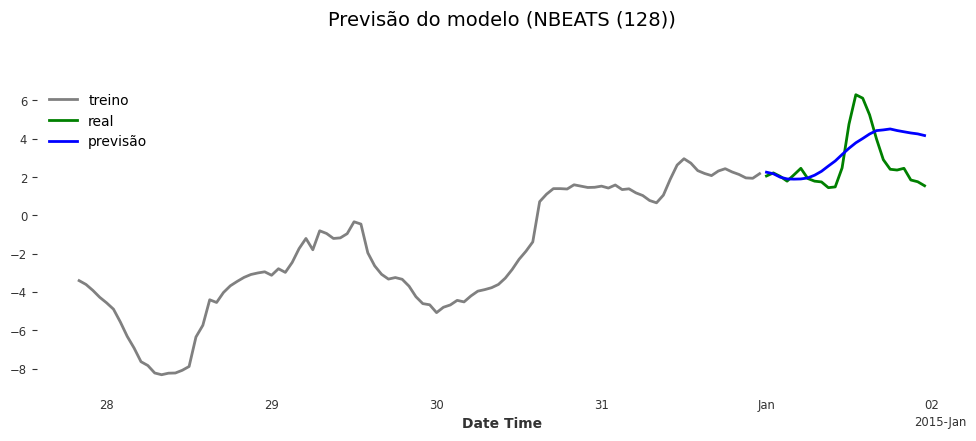

In [19]:
nbeats_forecast = nbeats_model.predict(24)
nbeats_forecast = scaler.inverse_transform(nbeats_forecast)

nbeats_model.save("model.pkl")

with mlflow.start_run(run_name="NBEATS"):
    mlflow.log_params(nbeats_model.model_params)

    mlflow.log_metric("mse", mse(test, nbeats_forecast))
    mlflow.log_metric("mae", mae(test, nbeats_forecast))
    mlflow.log_metric("rmse", rmse(test, nbeats_forecast))

    mlflow.set_tag("model", "NBEATS")
    mlflow.log_artifact("model.pkl")
    mlflow.log_artifact("scaler.pkl")

    plot_forecast(nbeats_forecast, train.tail(100), test, "NBEATS (128)")

In [20]:
nbeats_model = NBEATSModel(
    input_chunk_length=128,
    output_chunk_length=1,
    random_state=42,
    add_encoders={
        "datetime_attribute": {"past": ["hour", "month", "dayofyear", "day"]},
        "custom": {"past": [extract_season_of_the_year]},
        "transformer": Scaler(),
    },
    pl_trainer_kwargs={"accelerator": "gpu", "devices": [0]},
    batch_size=256,
)

nbeats_model.fit(
    train_transformed,
    verbose=True,
    epochs=1,
)

nbeats_model.save("model.pkl")

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 12.0 M
---------------------------------------------------
12.0 M    Trainable params
5.9 K     Non-trainable params
12.0 M    Total params
48.174    Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.


`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

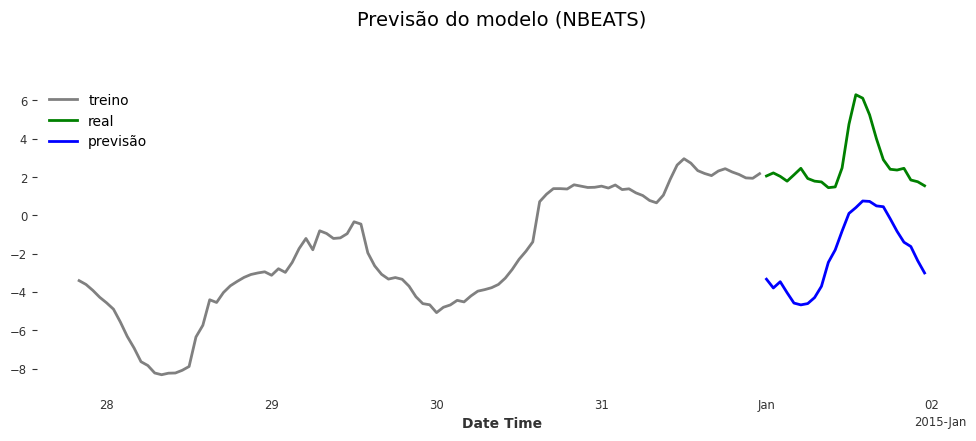

In [21]:
nbeats_forecast = nbeats_model.predict(24)
nbeats_forecast = scaler.inverse_transform(nbeats_forecast)

with mlflow.start_run(run_name="NBEATS"):
    mlflow.log_params(nbeats_model.model_params)

    mlflow.log_metric("mse", mse(test, nbeats_forecast))
    mlflow.log_metric("mae", mae(test, nbeats_forecast))
    mlflow.log_metric("rmse", rmse(test, nbeats_forecast))

    mlflow.set_tag("model", "NBEATS")
    mlflow.log_artifact("model.pkl")
    mlflow.log_artifact("scaler.pkl")

    plot_forecast(nbeats_forecast, train.tail(100), test, "NBEATS")